<a href="https://colab.research.google.com/github/dardan-gashi01/IN3060-CW/blob/main/test_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Coursework Submission (IN3060/INM460)

**Student name, ID and cohort:** Dardan Gashi (190003347) - UG


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_UG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_UG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'CW_Dataset.zip', 'Code', 'Models', 'Personal_Dataset', 'test_functions.ipynb']


### Load packages 

In the next cell you should load all the packages required to test your functions.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
import torch
from torchvision import datasets, models, transforms
import shutil
from skimage import img_as_ubyte, io, color
import cv2
import torch.nn as nn
import torch.nn.functional as F

# Test EmotionRecognition

This section should allow a quick test of the `EmotionRecognition` function. First, add cells with the code needed to load the necessary subroutines to make `EmotionRecognition` work.

unzip the test path and make it into a new folder to be able to run the functions on it

In [5]:
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

!cp '{zip_path}' .

!yes|unzip -q CW_Dataset.zip

!rm CW_Dataset.zip

In [19]:
import os, shutil
#function to make the directory if the one we are trying to make does not exist already
def make_dir_if_not_exists(path):
  if not os.path.isdir(path):
    os.mkdir(path)


def dataFolder2(trainImgPath, testImgPath, trainLabelPath, testLabelPath):
  #creating empty folders
  make_dir_if_not_exists('./DataFolder')
  make_dir_if_not_exists('./DataFolder/train')
  make_dir_if_not_exists('./DataFolder/test')
  #making the folders 1-7 to store our data inside them and have emotions as numbers
  for i in range(1,8):
    make_dir_if_not_exists(f'./DataFolder/train/{str(i)}')
    make_dir_if_not_exists(f'./DataFolder/test/{str(i)}')

  #initialisng the train and test paths
  trainPath = './DataFolder/train'
  testPath = './DataFolder/test'

  #reading the text file and splitting it from the space and storing the numbers in a dictionary and assigning it to the images we also read
  file_names = [file for file in os.listdir(trainImgPath) if file.endswith('.jpg')]
  parsed_data = {}
  with open (trainLabelPath, "r") as myfile:
    data = myfile.readlines()
    for line_data in data:
      file_name, number = line_data.strip().split(" ")
      parsed_data[file_name] = number

  #loading the images into the correct folders for the train folder
  for file in file_names:
    shutil.copy(f"{trainImgPath}/{file}", f"{trainPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")
    #print("image file: " + file + ' class: ' + parsed_data[file.replace("_aligned", "")])
  #load images into the correct folders

  #repeat the same step as above but this time for the test folder and test.txt
  file_names = [file for file in os.listdir(testImgPath) if file.endswith('.jpg')]
  parsed_data = {}
  with open (testLabelPath, "r") as myfile:
    data = myfile.readlines()
    for line_data in data:
      file_name, number = line_data.strip().split(" ")
      parsed_data[file_name] = number

  for file in file_names:
    shutil.copy(f"{testImgPath}/{file}", f"{testPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")
    #print("image file: " + file + ' class: ' + parsed_data[file.replace("_aligned", "")])
  #load images into the correct folders

In [20]:
dataFolder2('train', 'test', 'labels/list_label_train.txt', 'labels/list_label_test.txt')

In [21]:
#this is loading the images and labels from our folder into the X and y. This code was taken from the lab 7 tutorial where they loaded the images and labels
def import_selected_data(path, label_list):
    images = []
    labels = []

    if label_list is None:
        folder_names = [folder for folder in sorted(os.listdir(path)) if not folder.startswith('.')]
    else:
        folder_names = [folder for folder in sorted(os.listdir(path)) if folder in label_list]

    for folder in folder_names:
        file_names = [file for file in sorted(os.listdir(os.path.join(path, folder))) if file.endswith('.jpg')]
        for file in file_names:
            images.append(io.imread(os.path.join(path, folder, file)))
            labels.append(folder)

    return images, labels

**fixing up the data so that we can run tests on the pytorch model**

**Pytorch model class**

In [9]:
#neural network class 
class CNN(nn.Module):
  def __init__(self):
        super(CNN, self).__init__()
        #4 conv layers defined as in the CNN.ipynb file
        self.conv1 = nn.Conv2d(3,12,3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(12, 48, 3)
        self.conv3 = nn.Conv2d(48, 192,3)
        self.conv4 = nn.Conv2d(192, 768, 3)
        self.fc1 = nn.Linear(768*12*12, 140)
        self.fc2 = nn.Linear(140,98)
        self.fc3 = nn.Linear(98,7)

        #the forward pass function in the class so when we train
  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.pool(F.relu(self.conv3(x)))
      x = self.pool(F.relu(self.conv4(x)))
      x = x.view(-1, 768*12*12)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [10]:
cnn = CNN()

**function to load and transform our data**

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]

#this was taken from the lab9 where we transform our train and test images when we load them
def transform_Data(path):
  data_transforms = {
      'test': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(data_means, data_stds)
      ]),
  }

  image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                            data_transforms[x])
                    for x in ['test']}
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
                for x in ['test']}

  class_names = image_datasets['test'].classes
  
  return dataloaders, class_names

  

**functions to display our images with truth labels and predictions**

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

#this was also taken from lab9 to display the images and their prediction and truth labels
def visualize_model(model,DL, CN, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(DL['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f"Predicted: {CN[preds[j]]} \n Actual: {CN[labels[j]]}")
                imshow(inputs.cpu().data[j])
                #imshow(inputs.cpu().data[j])        # move back the data to the CPU for visualisation

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

**FIXING DATA FOR THEH HOGMLP and HOGSVM MODELS and so we can plot the images in the desired form**

In [13]:
from skimage.feature import hog
#created this function to hog feature extract our images in the test folders so we can run the prediction model
#this block of code is inspired from the SIFT feature extractor in lab 7 but its adapted to using hog feature extractors
def hogimages2(images, labels):
  hog_list_test = []
  hog_features_test=[]
  labels_list_test = []

#iterating all of the images to apply hog feature extractor to them

  for i in range(len(images)):
    
    img = img_as_ubyte(color.rgb2gray(images[i]))
    #for this I got this from doing the hog exercise in lab 6 and used https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/ to help me understand it and get an example
    #storing the features and the hog image when running the function on the grayscale image
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(12, 12), cells_per_block=(1, 1), visualize=True)

    hog_list_test.append(hog_image)
    labels_list_test.append(labels[i])
    hog_features_test.append(fd)


  hog_array_test = np.vstack(hog_list_test)
  hog_array_test = hog_array_test.reshape(len(labels_list_test), 100*100)
  #hog_array_test = hog_array_test.reshape(len(labels_list_test), hog_array_test[1]*hog_array_test[2])
  return hog_array_test

function to display our data with truth and predicted labels

In [14]:
#plotting images for hog models
def plotImages(images, labels, pred):
  fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharex=True, sharey=True)

  for i in range(4):
    ax[i].imshow(images[i], cmap=plt.cm.gray)
    ax[i].set_title(f'actual: {labels[i]} \n prediction: {pred[i]}')

  

### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `EmotionRecognition` to avoid having to reload them each time.

In [15]:
#hog-svm = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','hog-svm.joblib'))
cnn = torch.load((os.path.join(GOOGLE_DRIVE_PATH, 'Models/CNN.pth')), map_location=torch.device('cpu'))
hogsvm = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'HOGSVM.joblib'))
hogmlp = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'HOGMLP.joblib'))

**EmotionRecognition Function**

In [16]:
from random import shuffle
def EmotionRecognition(path_to_testset, model_type):
  
  #model_type values are SVM, MLP and CNN
  if(model_type == "hogsvm"):
    print("HOGSVM")
    X, y = import_selected_data(path_to_testset+'/test', label_list=['1', '2', '3','4','5','6','7'])
    testing = hogimages2(X, y)
    y_pred = hogsvm.predict(testing)
    plotImages(X,y,y_pred)
  elif(model_type == "hogmlp"):
    print("HOGMLP")
    X, y = import_selected_data(path_to_testset+'/test', label_list=['1', '2', '3','4','5','6','7'])
    testing = hogimages2(X, y)
    y_pred = hogmlp.predict(testing)
    plotImages(X,y,y_pred)
  elif(model_type == "cnn"):
    print("CNN")
    DataLoader, classNames = transform_Data(path_to_testset)
    cnn.eval()
    visualize_model(cnn, DataLoader, classNames)
  else:
    print("type a valid model")

Then, make a call to the `EmotionRecognition` function to see what results it produces. You must also indicate the syntax needed to test your different models.

CNN


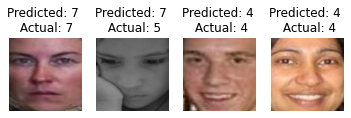

In [17]:
# Syntax for the next function is the following:
# 
# EmotionRecognition(path_to_testset, model_type)
# 
# where model_type can be one of
#   - hogsvm
#   - hogmlp
#   - cnn

path_to_testset = ('DataFolder')
EmotionRecognition(path_to_testset, 'cnn')

# Test EmotionRecognition in the wild

This section should allow a quick test of the `EmotionRecognition` on your `Personal_Dataset`.

CNN


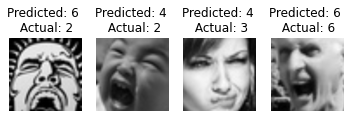

In [18]:
# Syntax for the next function is the following:
# 
# EmotionRecognition(path_to_testset, model_type)
# 
# where model_type can be one of
#   - hogsvm
#   - hogmlp
#   - cnn


path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset')
EmotionRecognition(path_to_testset, 'cnn')